In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

## Image segmentation with SAM 3

This notebook demonstrates how to use SAM 3 for image segmentation with text or visual prompts. It covers the following capabilities:

- **Text prompts**: Using natural language descriptions to segment objects (e.g., "person", "face")
- **Box prompts**: Using bounding boxes as exemplar visual prompts

# <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam3/blob/main/notebooks/sam3_image_predictor_example.ipynb">
#   <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
# </a>

In [24]:
### windows 환경 전용 trition 라이브러리 설치
!pip install triton-windows

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\rebel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
#Google colab을 사용할지 안사용할 지 설정
using_colab = False

In [12]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib scikit-learn
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam3.git'

In [14]:
import os

import matplotlib.pyplot as plt
import numpy as np

import sam3
from PIL import Image
from sam3 import build_sam3_image_model
from sam3.model.box_ops import box_xywh_to_cxcywh
from sam3.model.sam3_image_processor import Sam3Processor
from sam3.visualization_utils import draw_box_on_image, normalize_bbox, plot_results

sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")

In [15]:
import torch

# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices


### 부동소수점 정밀도 32비트 사용
### 대부분의 연산은 bfloat16을 사용하고 있음.

### 2026-02-05 기준 부동소수점 정밀도 설정
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

# Build Model (모델을 로딩) 반복할 경우 VRAM 누적이 되기 때문에 한번한 해야한다.

In [17]:
#bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"

#BPE 파일이 있는 sam3 패키지 디렉토리를 기준으로 설정변경
bpe_path = os.path.join(os.path.dirname(sam3.__file__), "assets", "bpe_simple_vocab_16e6.txt.gz")
model = build_sam3_image_model(bpe_path=bpe_path)

In [18]:
image_path = f"{sam3_root}/assets/images/test_image.jpg"
image = Image.open(image_path)
width, height = image.size
processor = Sam3Processor(model, confidence_threshold=0.5)
inference_state = processor.set_image(image)

# Text prompt

<div style="font-size:20px; color:rgb(106,171,115); font-weight:bold; border-bottom:1px solid rgb(106,171,115); margin-bottom:10px; display:inline-block;">plot_results(img, results) 매개변수</div> <br/>
<span style="color:orange; font-weight:bold;">[img]:</span> PIL Image 원본 이미지 <br/>
<span style="color:orange; font-weight:bold;">[result]:</span> 추론 결과 <br/>

```
    def plot_results(img, results):
        ###가로 12인치 세로 8인치의 그림창을 생성한다.
        plt.figure(figsize=(12, 8))
        plt.imshow(img)

        ###얼마나 많은 객체를 탐지했는지 수를 반환한다.
        nb_objects = len(results["scores"])
        print(f"found {nb_objects} object(s)")

        ###각 객체마다 순회를 돌린다.
        for i in range(nb_objects):
            ###객체마다 색상을 돌려사용한다
            color = COLORS[i % len(COLORS)]
            ### results["masks"][i]: 객체의 마스크 텐서 값이다.
            ### squeeze로 차원을 하나 줄인다.
            ### gpu 텐서에서 CPU로 옮기고 matplotlib로 그리도록 한다.
            ### color는 마스크의 색상을 의미하며 현재 반투명으로 칠하도록 되어있다.
            plot_mask(results["masks"][i].squeeze(0).cpu(), color=color)

            ###이미지의 높이와 너비를 표현한다.
            w, h = img.size

            ### results["scores"][i]는 [x1,y1,x2,y2]일 가능성이 큼
            prob = results["scores"][i].item()

            ### 이미지 크기 h,w와 박스 좌표 사각형을 그리는 용
            ### 신뢰도 값이나 텍스트 출력에 사용한다.
            plot_bbox(
                h,
                w,
                results["boxes"][i].cpu(),
                text=f"(id={i}, {prob=:.2f})",
                box_format="XYXY",
                color=color,
                relative_coords=False,
            )

```

found 12 object(s)


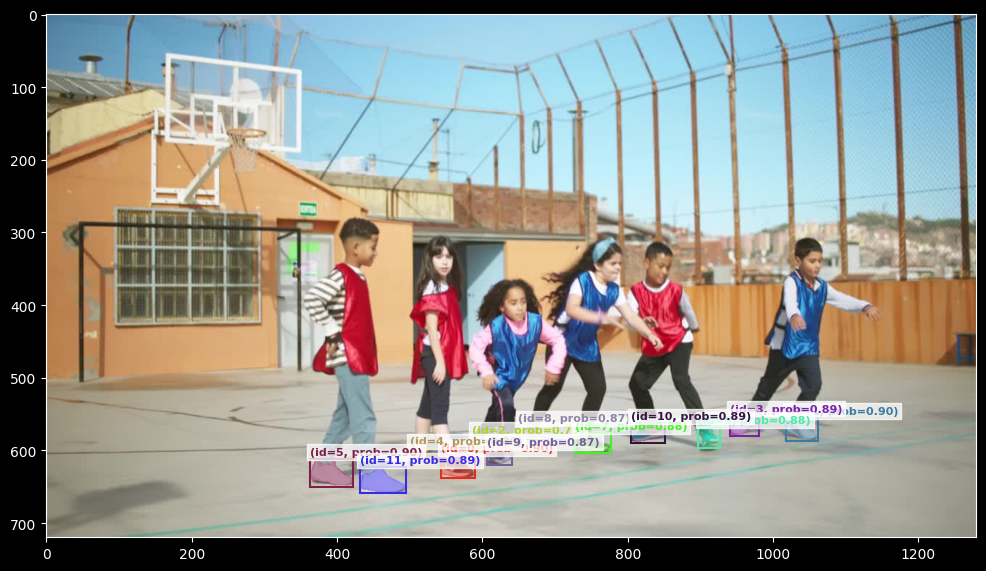

In [21]:
processor.reset_all_prompts(inference_state)

### set_text_prompt 프롬프트에 따른 범용 객체 분할 실행 함수
inference_state = processor.set_text_prompt(state=inference_state, prompt="shoe")

### 원본 이미지를 출력함.
img0 = Image.open(image_path)

### 원본 이미지와 추론 된 결과값을 매개변수로 사용
plot_results(img0, inference_state)

### Visual prompt: a single bounding box

Normalized box input: [0.41796875, 0.6527777910232544, 0.0859375, 0.5]


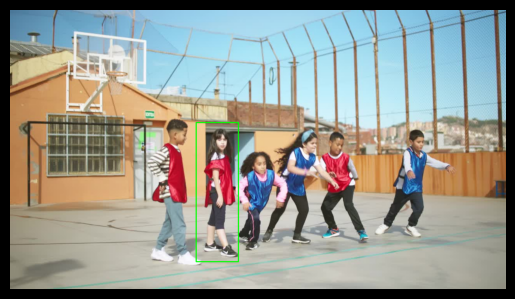

In [20]:
# Here the box is in  (x,y,w,h) format, where (x,y) is the top left corner.
box_input_xywh = torch.tensor([480.0, 290.0, 110.0, 360.0]).view(-1, 4)
box_input_cxcywh = box_xywh_to_cxcywh(box_input_xywh)

norm_box_cxcywh = normalize_bbox(box_input_cxcywh, width, height).flatten().tolist()
print("Normalized box input:", norm_box_cxcywh)

processor.reset_all_prompts(inference_state)
inference_state = processor.add_geometric_prompt(
    state=inference_state, box=norm_box_cxcywh, label=True
)

img0 = Image.open(image_path)
image_with_box = draw_box_on_image(img0, box_input_xywh.flatten().tolist())
plt.imshow(image_with_box)
plt.axis("off")  # Hide the axis
plt.show()

In [ ]:
plot_results(img0, inference_state)

### Visual prompt: multi-box prompting (with positive and negative boxes)

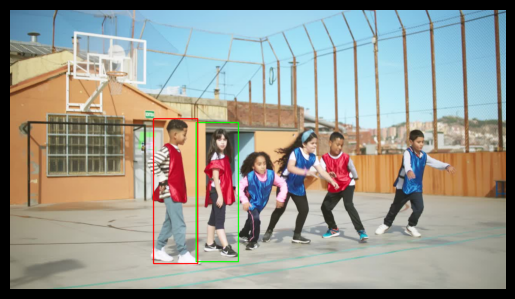

In [23]:
box_input_xywh = [[480.0, 290.0, 110.0, 360.0], [370.0, 280.0, 115.0, 375.0]]
box_input_cxcywh = box_xywh_to_cxcywh(torch.tensor(box_input_xywh).view(-1,4))
norm_boxes_cxcywh = normalize_bbox(box_input_cxcywh, width, height).tolist()

box_labels = [True, False]

processor.reset_all_prompts(inference_state)

for box, label in zip(norm_boxes_cxcywh, box_labels):
    inference_state = processor.add_geometric_prompt(
        state=inference_state, box=box, label=label
    )

img0 = Image.open(image_path)
image_with_box = img0
for i in range(len(box_input_xywh)):
    if box_labels[i] == 1:
        color = (0, 255, 0)
    else:
        color = (255, 0, 0)
    image_with_box = draw_box_on_image(image_with_box, box_input_xywh[i], color)
plt.imshow(image_with_box)
plt.axis("off")  # Hide the axis
plt.show()

In [ ]:
plot_results(img0, inference_state)